In [15]:
import os

os.chdir('/opt/project')
print(os.getcwd())

/opt/project


# Registration

In [ ]:
import warnings
import pandas as pd
import os
import shutil

# for copying meningioma data from the original folder structure to one suitable with autorad

from multiprocessing import Pool


def process_patient(patient_info):
    patient_src, dest_patient_folder = patient_info
    expected_files = {'ADC.nii.gz', 'flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'mask.nii.gz'}
    found_files = set()
    for file in os.listdir(patient_src):
        if file.endswith('.nii') or file.endswith('.gz'):
            if 'ADC' in file:
                new_filename = 'ADC.nii'
            elif 'flair' in file:
                new_filename = 'flair.nii.gz'
            elif 't1ce' in file:
                new_filename = 't1ce.nii.gz'
            elif 't1' in file:
                new_filename = 't1.nii.gz'
            elif 't2' in file:
                new_filename = 't2.nii.gz'
            elif '_1.nii' in file or '_2.nii' in file or '_3.nii' in file:
                new_filename = 'mask.nii.gz'
            else:
                warnings.warn(f"Unexpected file {file} in patient folder {patient_src}")
                continue

            src_file_path = os.path.join(patient_src, file)
            dest_file_path = os.path.join(dest_patient_folder, new_filename)
            shutil.copy(src_file_path, dest_file_path)
            print(f"Copied file {src_file_path} to {dest_file_path}")

            found_files.add(new_filename)

    if expected_files != found_files:
        missing_files = expected_files - found_files
        warnings.warn(f"Missing files {missing_files} in patient folder {patient_src}")

    return dest_patient_folder


def copy_patient_data(src_dir, dest_dir, n_cpu=2):
    """
    Copies patient data from the source directory to the destination directory
    while maintaining an ascending pattern of integer-based patient IDs. The function
    creates a mapping of patient IDs, grades, and their original data paths,
    and saves the mapping to a CSV file. It also renames the files as per the required format.

    Parameters:
        src_dir (str): The path to the source directory containing patient data organized by grades.
        dest_dir (str): The path to the destination directory where the copied patient data will be stored.

    Returns:
        None: The function performs the copy operation, file renaming, and saves the mapping to a CSV file.

    Raises:
        FileNotFoundError: If any of the expected files are missing.
        ValueError: If there are additional files that don't match the pattern.
    """
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    patient_data = []
    patient_info_list = []
    for grade_folder in os.listdir(src_dir):
        grade_path = os.path.join(src_dir, grade_folder)
        if os.path.isdir(grade_path):
            for patient_folder in os.listdir(grade_path):
                patient_src = os.path.join(grade_path, patient_folder)
                if os.path.isdir(patient_src):
                    dest_patient_id = len(os.listdir(dest_dir)) + 1
                    dest_patient_folder = os.path.join(dest_dir, f"ID_{dest_patient_id}")
                    os.makedirs(dest_patient_folder, exist_ok=True)
                    patient_info_list.append((patient_src, dest_patient_folder))
                    grade = 1 if grade_folder == 'Grade1Data' else 2
                    patient_data.append((f"ID_{dest_patient_id}", grade, patient_src))

    # Process patient data in parallel using multiprocessing
    with Pool(n_cpu) as pool:
        dest_patient_folders = pool.map(process_patient, patient_info_list)

    # Create a pandas DataFrame from the patient_data list
    df = pd.DataFrame(patient_data, columns=["Patient_ID", "Grade", "Original_Data_Path"])

    # Save the DataFrame to a CSV file
    df.to_csv("patient_grade_mapping.csv", index=False)


copy_patient_data('./data/meningioma', './data/meningioma_data')

In [ ]:
from src.preprocessing.registration import register_patients

register_patients(data_dir='./data', 
                  static_stem='t1ce.nii.gz',
                    moving_stem='ADC.nii', 
                    utput_stem='registered_adc.nii.gz', 
                    transform_method='rigid')

# Test Autoencoder Performance

In [ ]:
import matploglib.pyplot as plt

def plot_debug(stk_image):
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(stk_image)[5, :, :], cmap='gray')
    plt.show()


def plot_slices(output_tensor, slice_index, num_samples=5, original_tensor=None,
                title=None, save_dir=None):
    """
    Plot a slice from each image modality of the output tensor for a specified number of samples.

    Parameters:
        output_tensor (torch.Tensor): The output tensor from the autoencoder.
        slice_index (int): The index of the slice to be plotted.
        image_modalities (list): List of image modality names.
        num_samples (int): The number of samples to plot.
        title_prefix (str): Prefix to add to the plot titles.

    Returns:
        None
    """
    batch_size, num_modalities, length, width, height = output_tensor.shape

    for sample_idx in range(min(num_samples, batch_size)):
        plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

        for modality_idx in range(num_modalities):
            plt.subplot(2, num_modalities, modality_idx + 1)
            plt.imshow(output_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
            plt.title(f'generated Sample {sample_idx + 1}, {modality_idx}')
            plt.axis('off')

        if original_tensor is not None:
            for modality_idx in range(num_modalities):
                plt.subplot(2, num_modalities, num_modalities + modality_idx + 1)
                plt.imshow(original_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
                plt.title(f'original Sample {sample_idx + 1}, {modality_idx}')
                plt.axis('off')

        if title is not None:
            plt.suptitle(title)
        if save_dir is not None:
            plt.savefig(f'{save_dir}_{sample_idx}.png')

        plt.show()                                    

In [157]:
from torchio import SubjectsDataset
from src.dataset import TransformingDataLoader, SkorchSubjectsDataset
from skorch.callbacks import EarlyStopping, GradientNormClipping
from src.models.autoencoder import SegResNetVAE2, BetaVAELoss, Encoder
from src.pipeline.pipeline_components import get_multimodal_feature_dataset, split_feature_dataset
import torchio as tio
from datetime import datetime
import torch


# setup dataset, extract features, split the data
feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df='tests/meningioma_feature_dataset.csv',
                                                 additional_features=['ID']
                                                 )

id_list = feature_dataset.X['ID'].to_numpy()

dataset_train_transform = tio.Compose([tio.Resample((1, 1, 1)),
                                                    tio.ToCanonical(),
                                                    tio.Mask(masking_method='mask', outside_value=0),
                                                    tio.CropOrPad(target_shape=(96, 96, 96), mask_name='mask'),
                                                    tio.ZNormalization(masking_method='mask')])

encoder = Encoder(SegResNetVAE2,
                    module__input_image_size=[96, 96, 96],
                    module__spatial_dims=3,
                    module__in_channels=5,
                    module__out_channels=5,
                    module__dropout_prob=0.2,
                    module__init_filters=32,
                    batch_size=3,
                    # output_format='pandas',
                    criterion=BetaVAELoss,
                    max_epochs=200,
                    callbacks=[EarlyStopping(load_best=True),
                               GradientNormClipping(1),
                               ],
                    optimizer=torch.optim.AdamW,
                    lr=0.001,
                    iterator_train=TransformingDataLoader,
                    iterator_train__augment_transforms=tio.Compose([tio.RandomGamma(log_gamma=0.1, label_keys='mask'),
                                                                    tio.RandomAffine(p=0.5, label_keys='mask',
                                                                                     scales=0.1, degrees=0,
                                                                                     translation=0, isotropic=True),
                                                                    tio.RandomFlip(flip_probability=0.5,
                                                                                   label_keys='mask', axes=(0, 1, 2))
                                                                    ]),
                    iterator_train__num_workers=15,
                    iterator_train__shuffle=True,
                    iterator_valid__num_workers=4,
                    dataset=SkorchSubjectsDataset,
                    dataset__transform=dataset_train_transform,
                    criterion__kld_weight=0.1,
                    device='cuda'
                    )

encoder.initialize()
print(list(encoder.get_all_learnable_params()))


[('convInit.conv.weight', Parameter containing:
tensor([[[[[-0.0725,  0.0504, -0.0178],
           [-0.0569,  0.0277,  0.0530],
           [-0.0302,  0.0074, -0.0250]],

          [[ 0.0279, -0.0332, -0.0667],
           [-0.0712, -0.0422,  0.0463],
           [ 0.0374,  0.0153,  0.0797]],

          [[-0.0572, -0.0540,  0.0555],
           [-0.0355,  0.0372,  0.0499],
           [-0.0432,  0.0813, -0.0705]]],


         [[[-0.0043, -0.0382,  0.0744],
           [-0.0343, -0.0149,  0.0011],
           [ 0.0675, -0.0338,  0.0169]],

          [[-0.0113, -0.0522, -0.0025],
           [-0.0546, -0.0295, -0.0031],
           [-0.0095, -0.0810,  0.0569]],

          [[-0.0117, -0.0585,  0.0152],
           [-0.0456,  0.0129,  0.0703],
           [-0.0451,  0.0092,  0.0569]]],


         [[[ 0.0454,  0.0300, -0.0290],
           [-0.0174,  0.0823, -0.0694],
           [ 0.0442,  0.0288,  0.0091]],

          [[-0.0177,  0.0602,  0.0553],
           [-0.0048,  0.0371,  0.0034],
           [-0

# Find Optimal shape of Encoder to crop to

In [ ]:
from src.pipeline.pipeline_components import get_multimodal_feature_dataset
from src.dataset.skorch_subject_ds import SkorchSubjectsDataset
import torchio as tio
import numpy as np


feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df='tests/meningioma_feature_dataset.csv',
                                                 additional_features=['ID']
                                                 )

ds = SkorchSubjectsDataset(feature_dataset.X.ID, None, data_dir='./data/meningioma_data',
                           image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                           mask_stem='mask',
                           transform=tio.Compose([tio.Resample(target=1),tio.ToCanonical(),tio.CropOrPad(target_shape=None, mask_name='mask')]))

shapes = [ds[i][0].shape for i in range(len(ds))]

np_shapes = np.concatenate(shapes)

np.unique(np_shapes, return_counts=True)

# Explainer

In [9]:
import mlflow
from autorad.models.classifier import MLClassifier
from autorad.inference import infer_utils
import shap
from src.analysis.shap import get_shap_values, plot_shap_bar, summate_shap_bar
import matplotlib.pyplot as plt

model1_run_id = '54b618ca89a549eda3d87a1a57a550fe' #radiomics only
model2_run_id = '60e74372c5844fd0aa28bddefc58acd9' #radiomics and deep learning




In [10]:
model1_shap_values, dataset_df, dataset_splits = get_shap_values(model1_run_id)
model2_shap_values, _, _ = get_shap_values(model2_run_id, dataset_df, dataset_splits)

PermutationExplainer explainer: 195it [39:47, 12.31s/it]                                                                                                                        


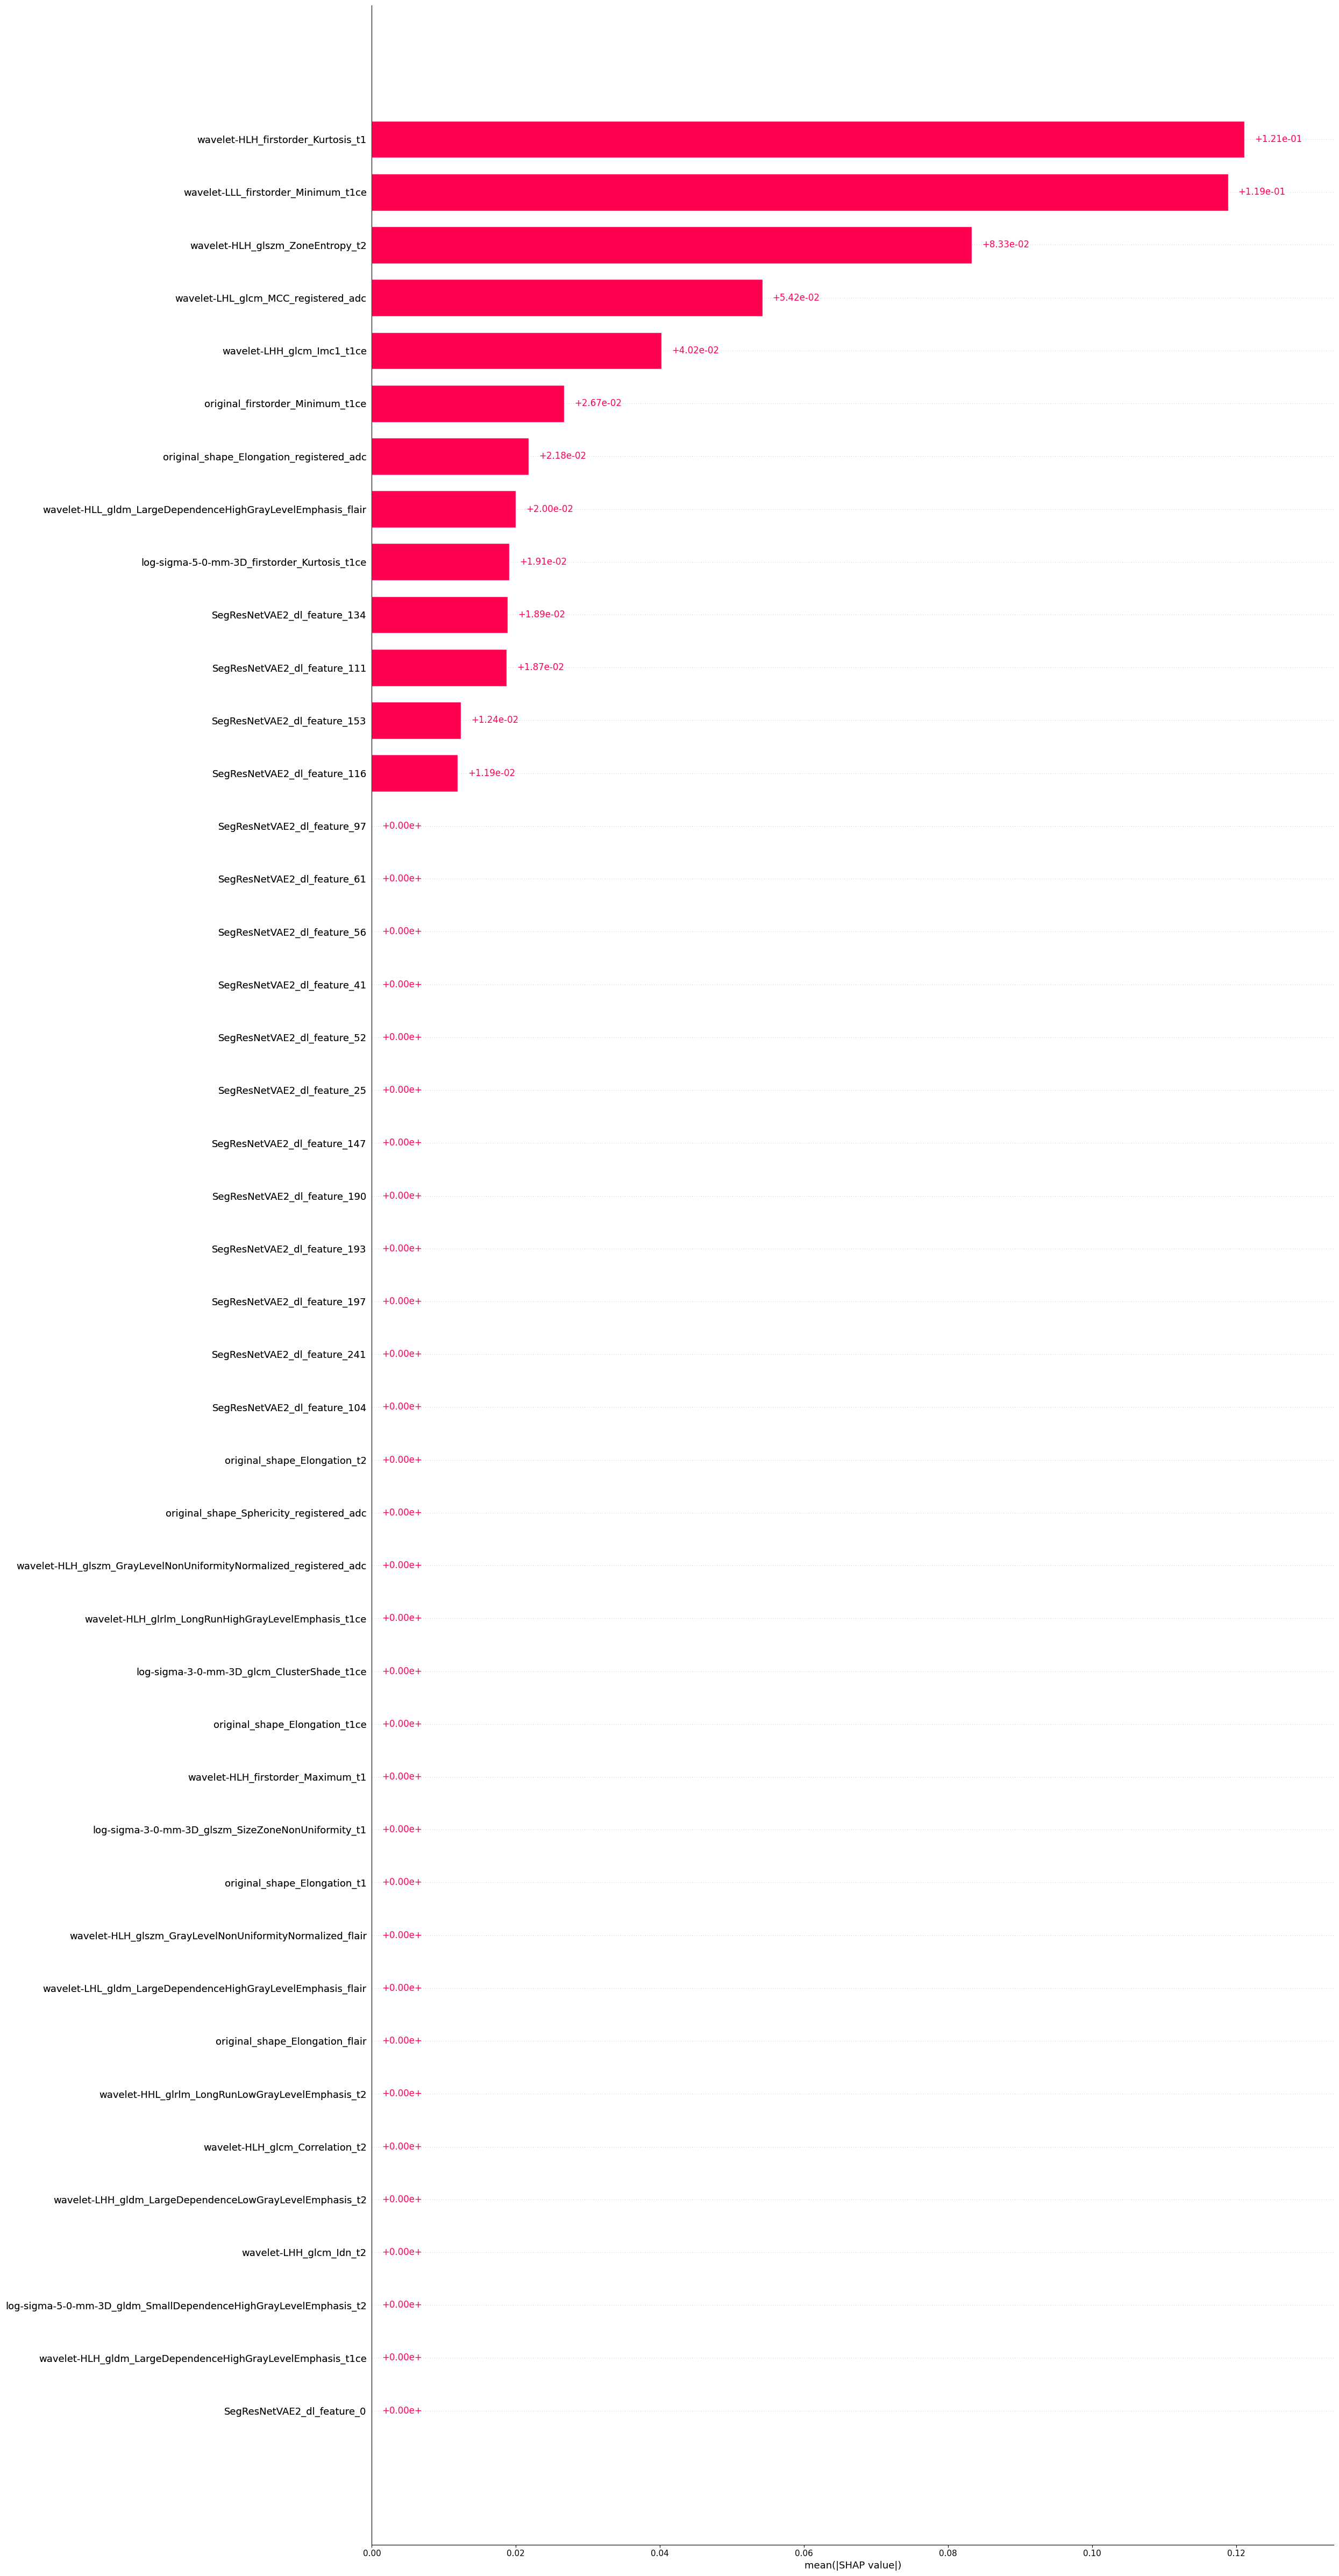

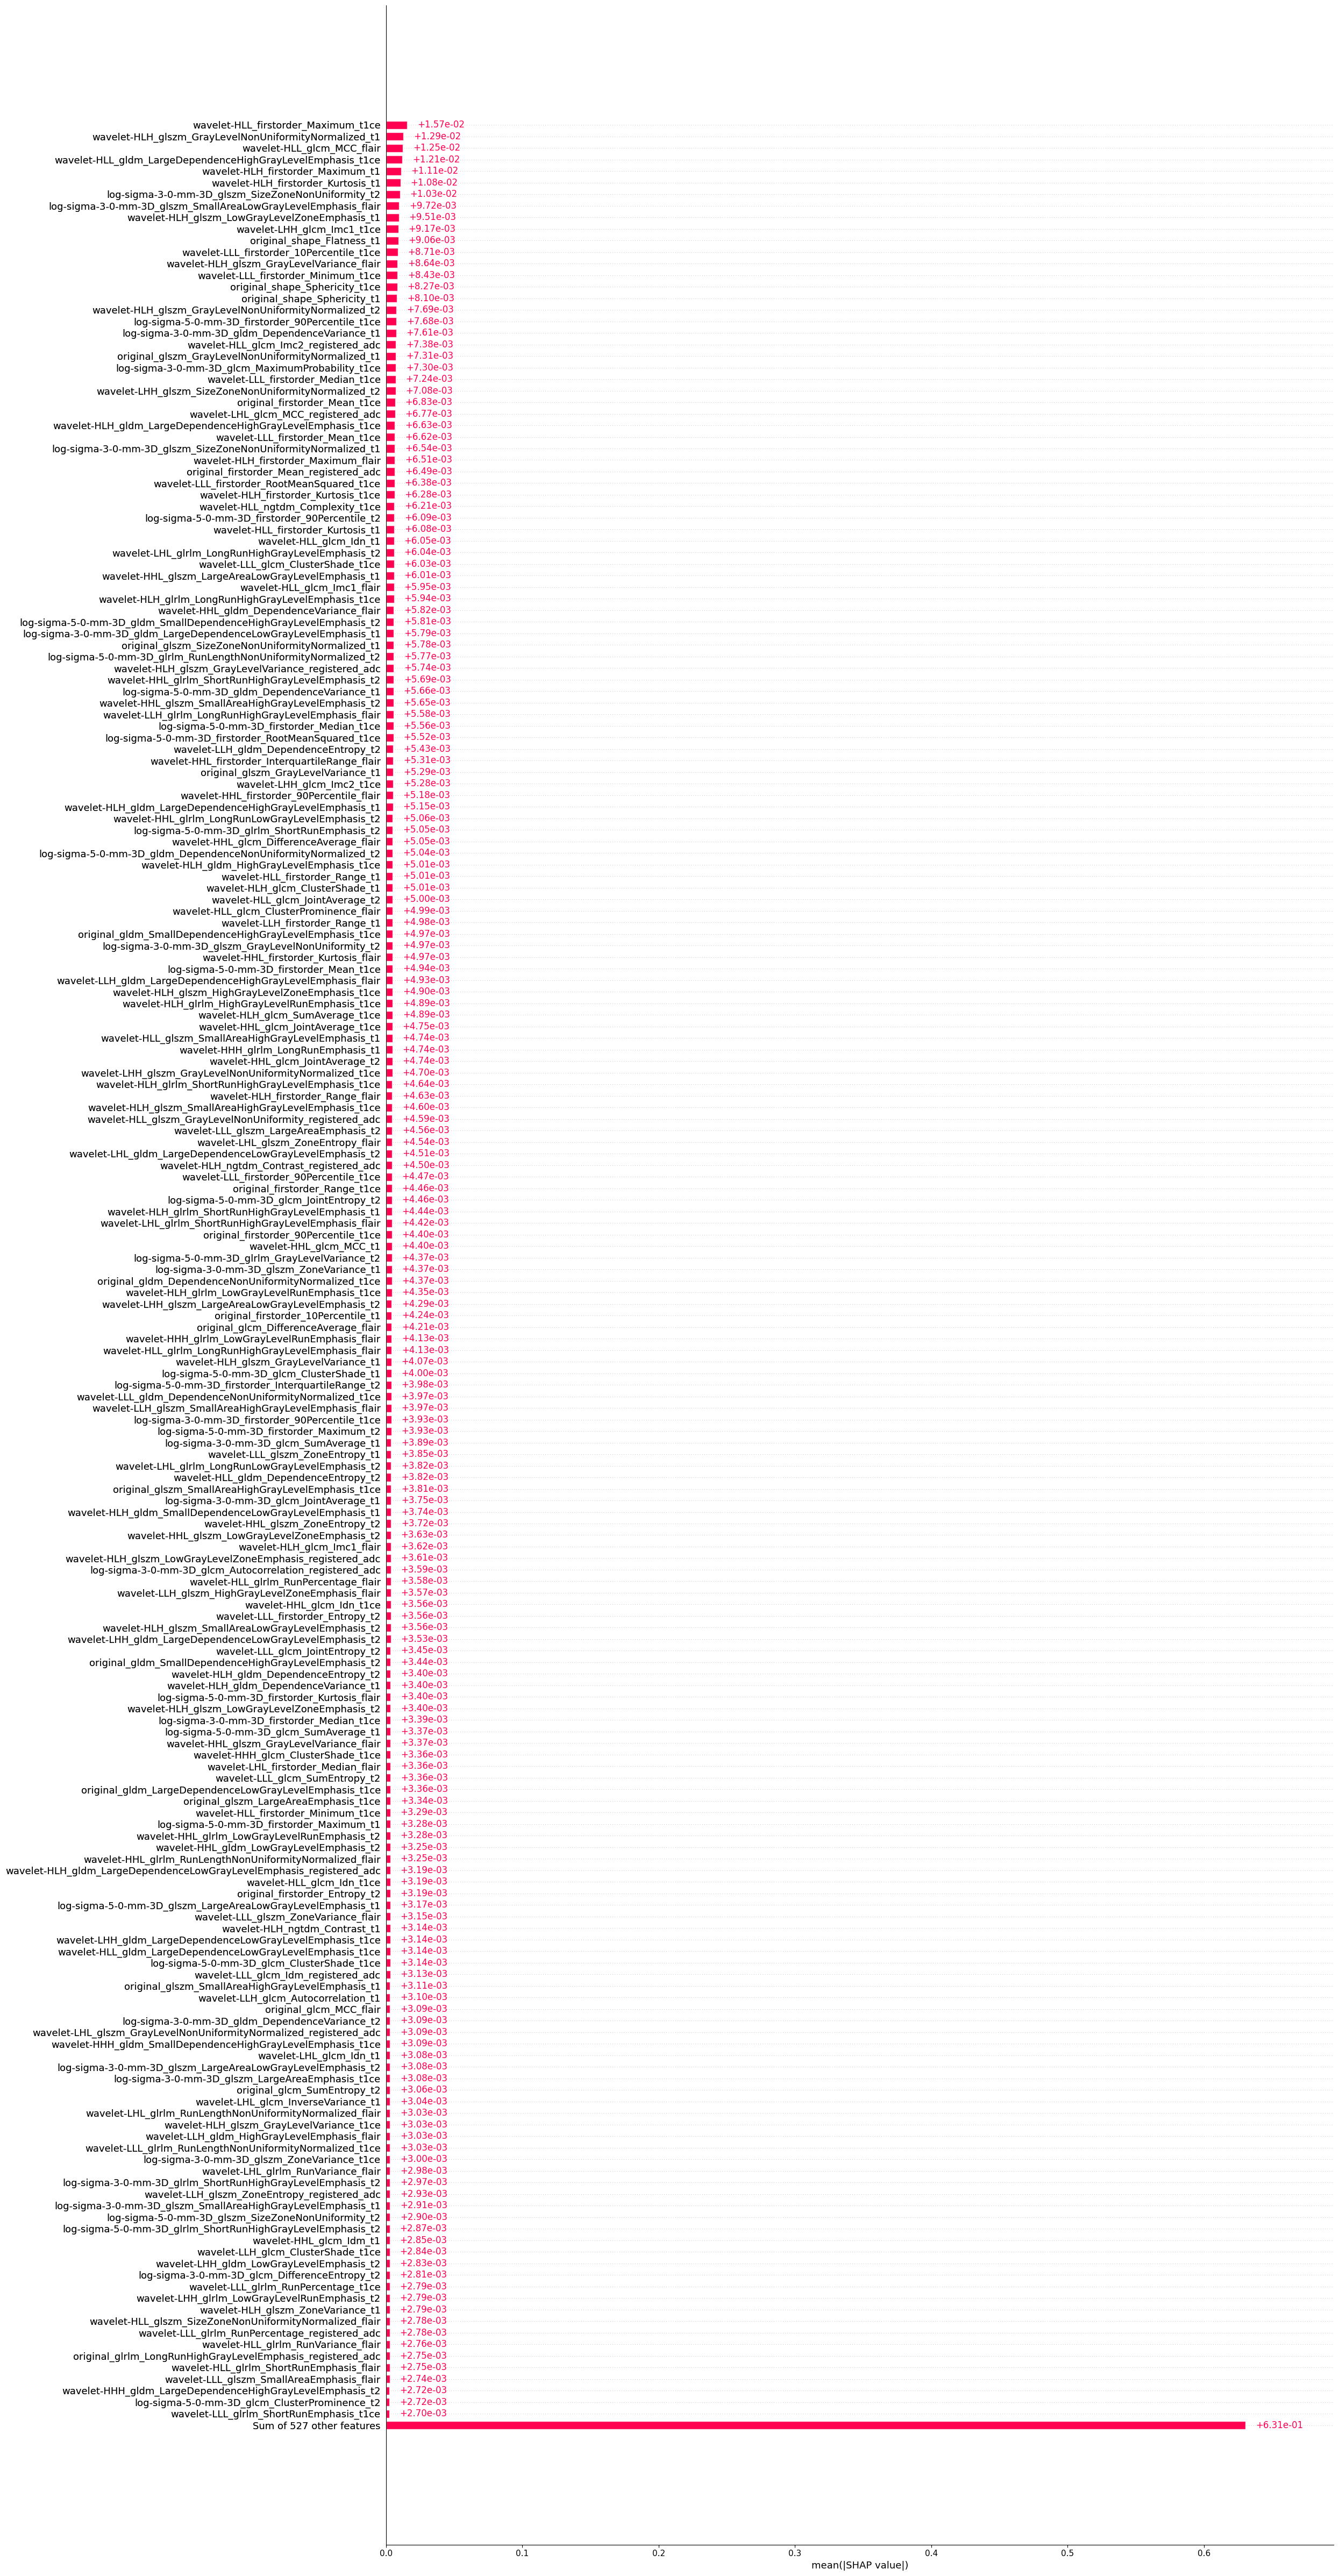

In [11]:
model1_output_dir = 'outputs/meningioma+autoencoder/2024-01-06-01-06-13'
model2_output_dir = 'outputs/meningioma/2024-01-06-00-08-33'

max_display=200

plot_shap_bar(model1_shap_values, max_display=max_display, save_dir=model1_output_dir, size=(25,48))
plt.show()
plot_shap_bar(model2_shap_values, max_display=max_display, save_dir=model2_output_dir, size=(25,48))
plt.show()


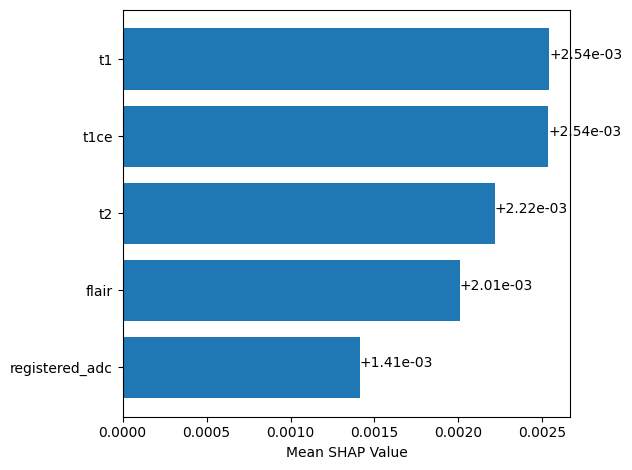

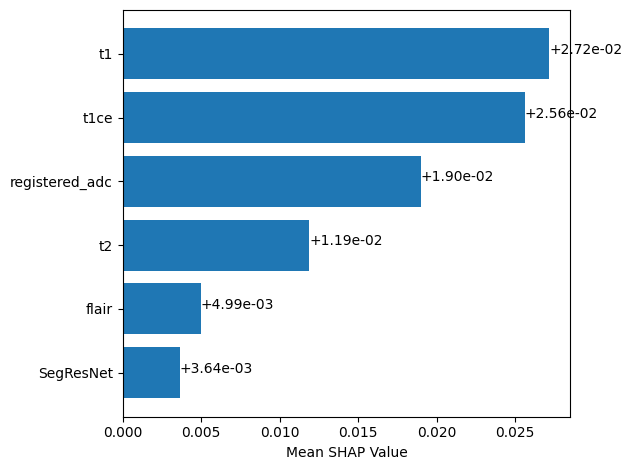

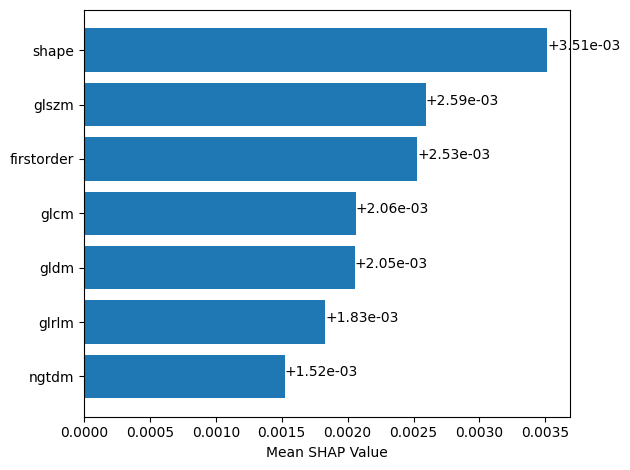

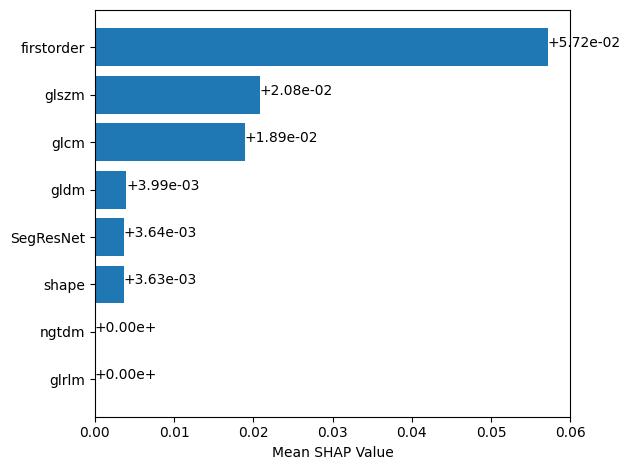

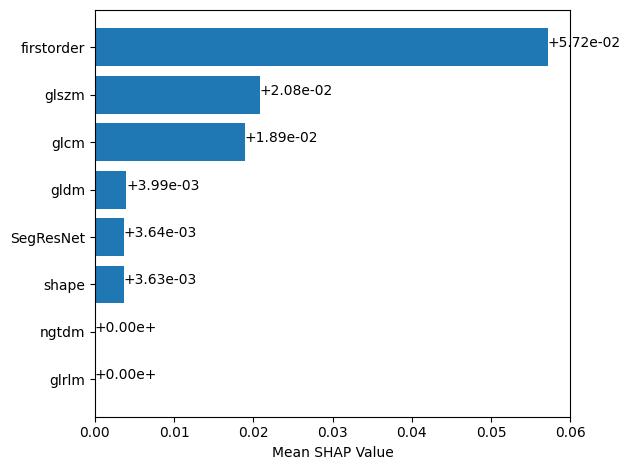

In [156]:
summate_shap_bar(model2_shap_values, ['registered_adc', 't2', 'flair', 't1', 't1ce'])
summate_shap_bar(model1_shap_values, ['registered_adc', 't2', 'flair', 't1', 't1ce', 'SegResNet'])

summate_shap_bar(model2_shap_values, ['shape', 'firstorder', 'glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm'])
summate_shap_bar(model1_shap_values, ['shape', 'firstorder', 'glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm', 'SegResNet'])

# Other code:

In [13]:
from datetime import datetime

def find_time_difference(time1, time2, format='%Y-%m-%d %H:%M:%S,%f'):

    date1 = datetime.strptime(time1, format)
    date2 = datetime.strptime(time2, format)
    difference = date2-date1
    return difference

find_time_difference('2024-01-06 00:56:17,550', '2024-01-06 01:00:51,369')/500

datetime.timedelta(microseconds=547638)

In [ ]:
samples_sizes=[16,32,64,118]
confidence_intervals=[(0.5,0.6), (0.6, 0.7), (0.65, 0.75), (0.67, 0.8)]

def plot_confidence_intervals(sample_sizes, confidence_intervals, y_label='roc_auc', save_dir=None):
    """
    :param sample_sizes: list of numbers
    :param confidence_intervals: expects in list of tuples [(a,b),(c,d)...]
    :return:
    """
    starts, ends = zip(*confidence_intervals)
    plt.plot(sample_sizes, starts)
    plt.plot(sample_sizes, ends)
    plt.fill_between(sample_sizes, starts, ends, alpha=0.2)
    plt.xlabel('Sample Size')
    plt.ylabel(y_label)
    plt.grid(True)
    if save_dir is not None:
        plt.savefig(save_dir, dpi=300)
    plt.show()

Mean of empty slice.
invalid value encountered in scalar divide


(nan, 8, nan)


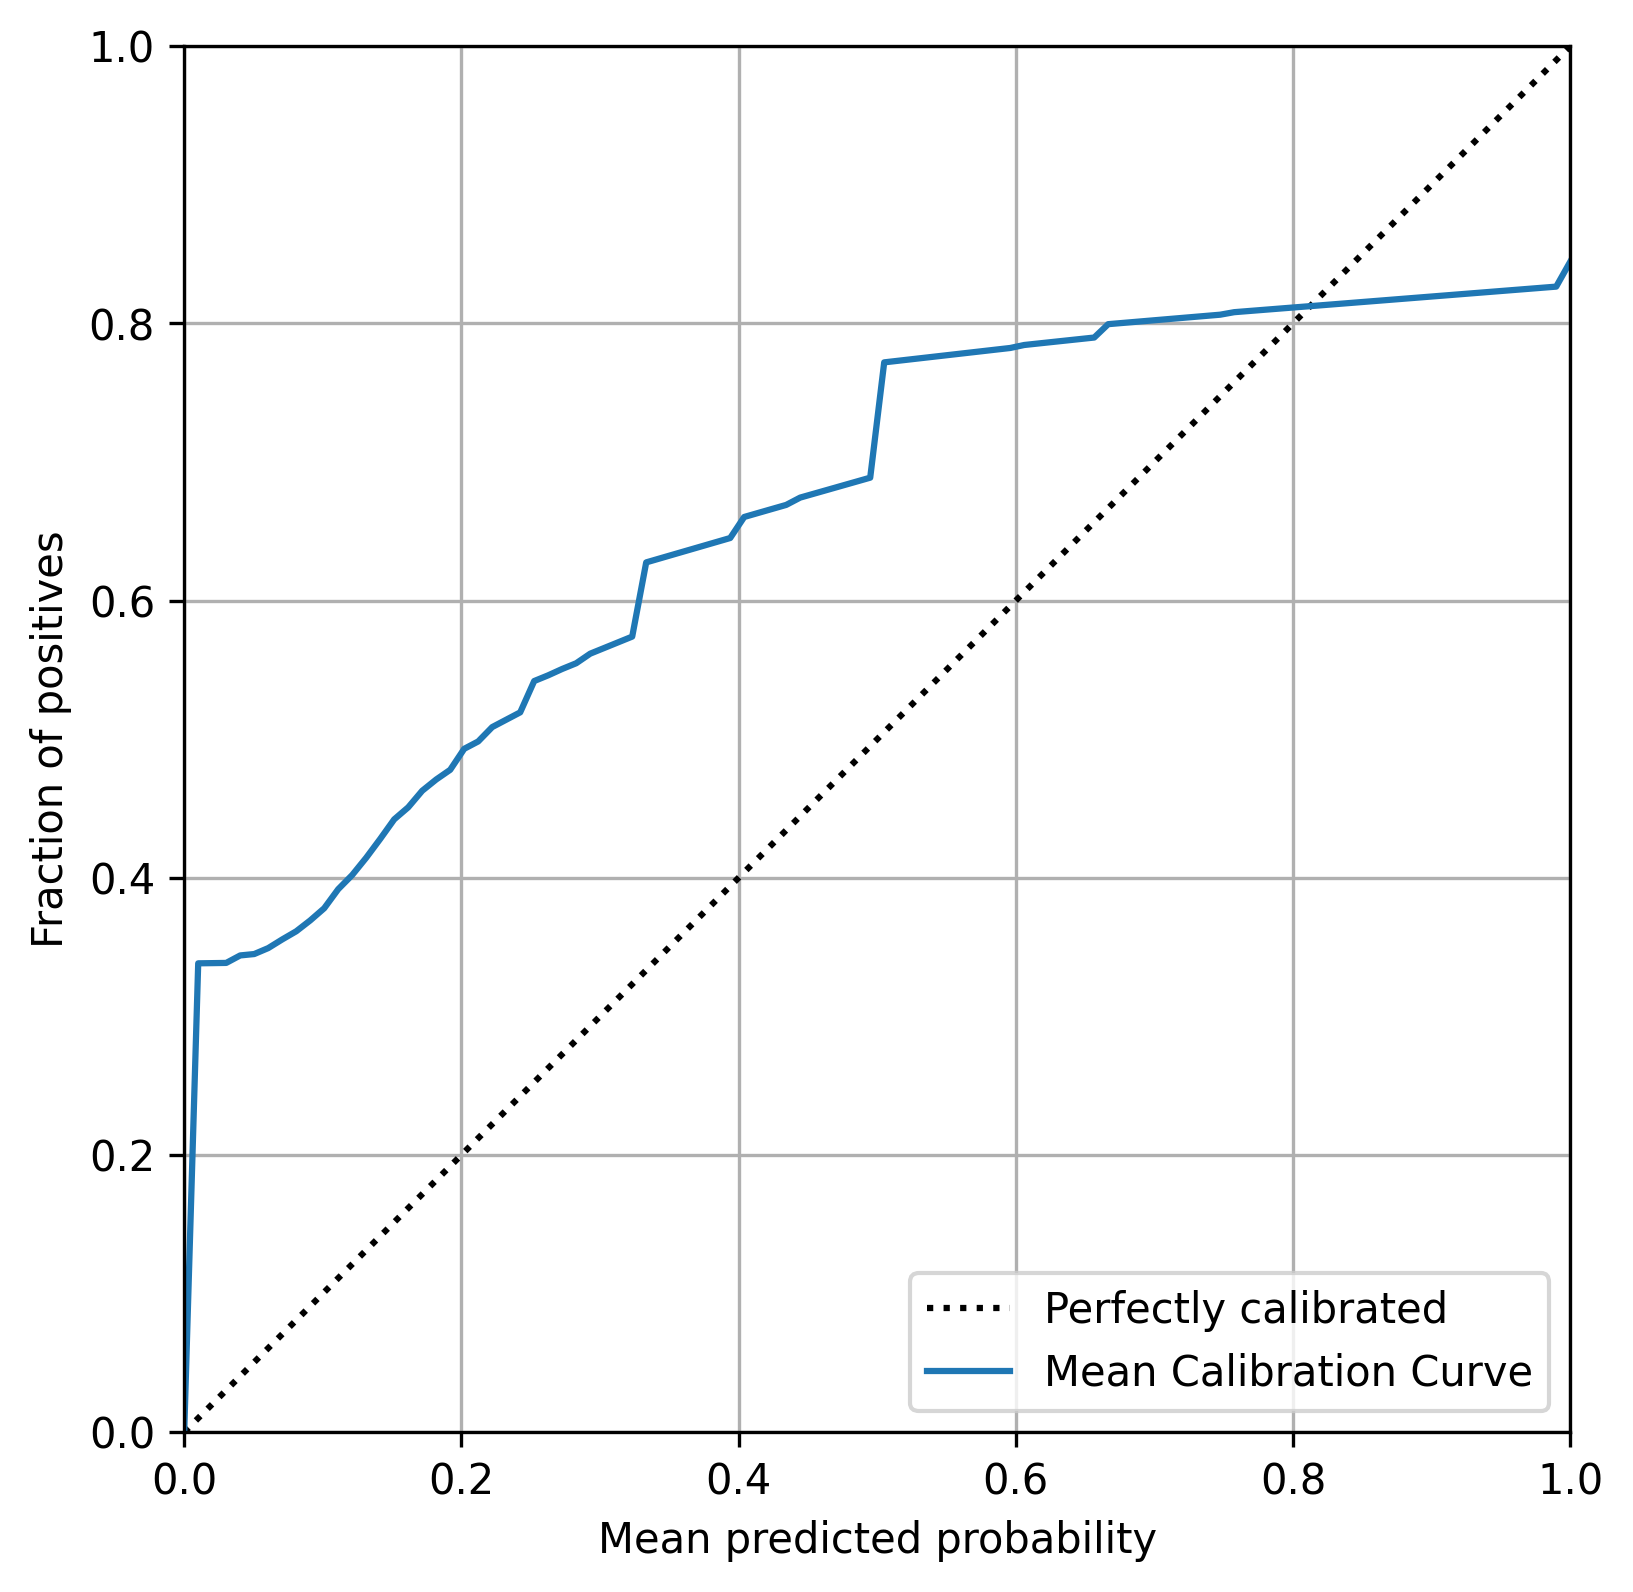

(<Figure size 2400x1800 with 1 Axes>,
 <AxesSubplot:xlabel='Mean predicted probability', ylabel='Fraction of positives'>)

In [152]:
import pickle
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np
from scipy.stats import chi2


def plot_calibration_curve(run, save_dir=None):
    if isinstance(run, str):
        run = pd.Series(dict(mlflow.get_run(run).info))

    artifact_uri = run.artifact_uri.removeprefix('file://')

    with open(os.path.join(artifact_uri, 'bootstrap_scores.pkl'), 'rb') as f:
        bootstrap_scores = pickle.load(f)

    y_true_y_preds = [score[2] for score in bootstrap_scores]

    mean_prob_pred = np.linspace(0, 1, 100)
    mean_prob_true = np.zeros_like(mean_prob_pred)

    for y_true, y_preds in y_true_y_preds:
        prob_true, prob_pred = calibration_curve(y_true, y_preds)
        interp_prob_true = np.interp(mean_prob_pred, prob_true, prob_pred)
        interp_prob_true[0] = 0.0
        mean_prob_true += interp_prob_true

    mean_prob_true /= len(y_true_y_preds)

    print(hosmer_lemeshow_test(mean_prob_true, mean_prob_pred))

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax.plot([0, 1], [0, 1], "k:", label='Perfectly calibrated')
    ax.plot(mean_prob_pred, mean_prob_true, label='Mean Calibration Curve')
    ax.legend(loc="lower right")
    ax.set(xlabel="Mean predicted probability", ylabel="Fraction of positives")
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.grid(True)

    if save_dir is None:
        plt.show()
    else:
        fig.savefig(save_dir, dpi=300)

    return fig, ax
    # prob_true_mean = np.mean(np.array(prob_true_list))
    # prob_pred_mean = np.mean(np.array(prob_pred_list))

    # print(len(prob_true_mean))


def hosmer_lemeshow_test(prob_true, prob_pred, num_bins=10):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(prob_pred, bin_edges[1:-1])

    # Calculate observed event rate and average predicted probability for each bin
    event_rate = np.zeros(num_bins)
    mean_predicted_prob = np.zeros(num_bins)
    for i in range(num_bins):
        event_rate[i] = np.mean(prob_true[bin_indices == i + 1])
        mean_predicted_prob[i] = np.mean(prob_pred[bin_indices == i + 1])

    # Calculate expected event rate for each bin
    expected_event_rate = mean_predicted_prob * event_rate.mean()

    # Compute the chi-square statistic
    chi_squared = np.sum((event_rate - expected_event_rate) ** 2 / expected_event_rate)

    # Calculate degrees of freedom
    df = num_bins - 2  # 2 parameters: intercept and slope

    # Calculate p-value
    p_value = 1 - chi2.cdf(chi_squared, df)

    return chi_squared, df, p_value


plot_calibration_curve(model1_run_id)
# plot_calibration_curve(model2_run_id)



    

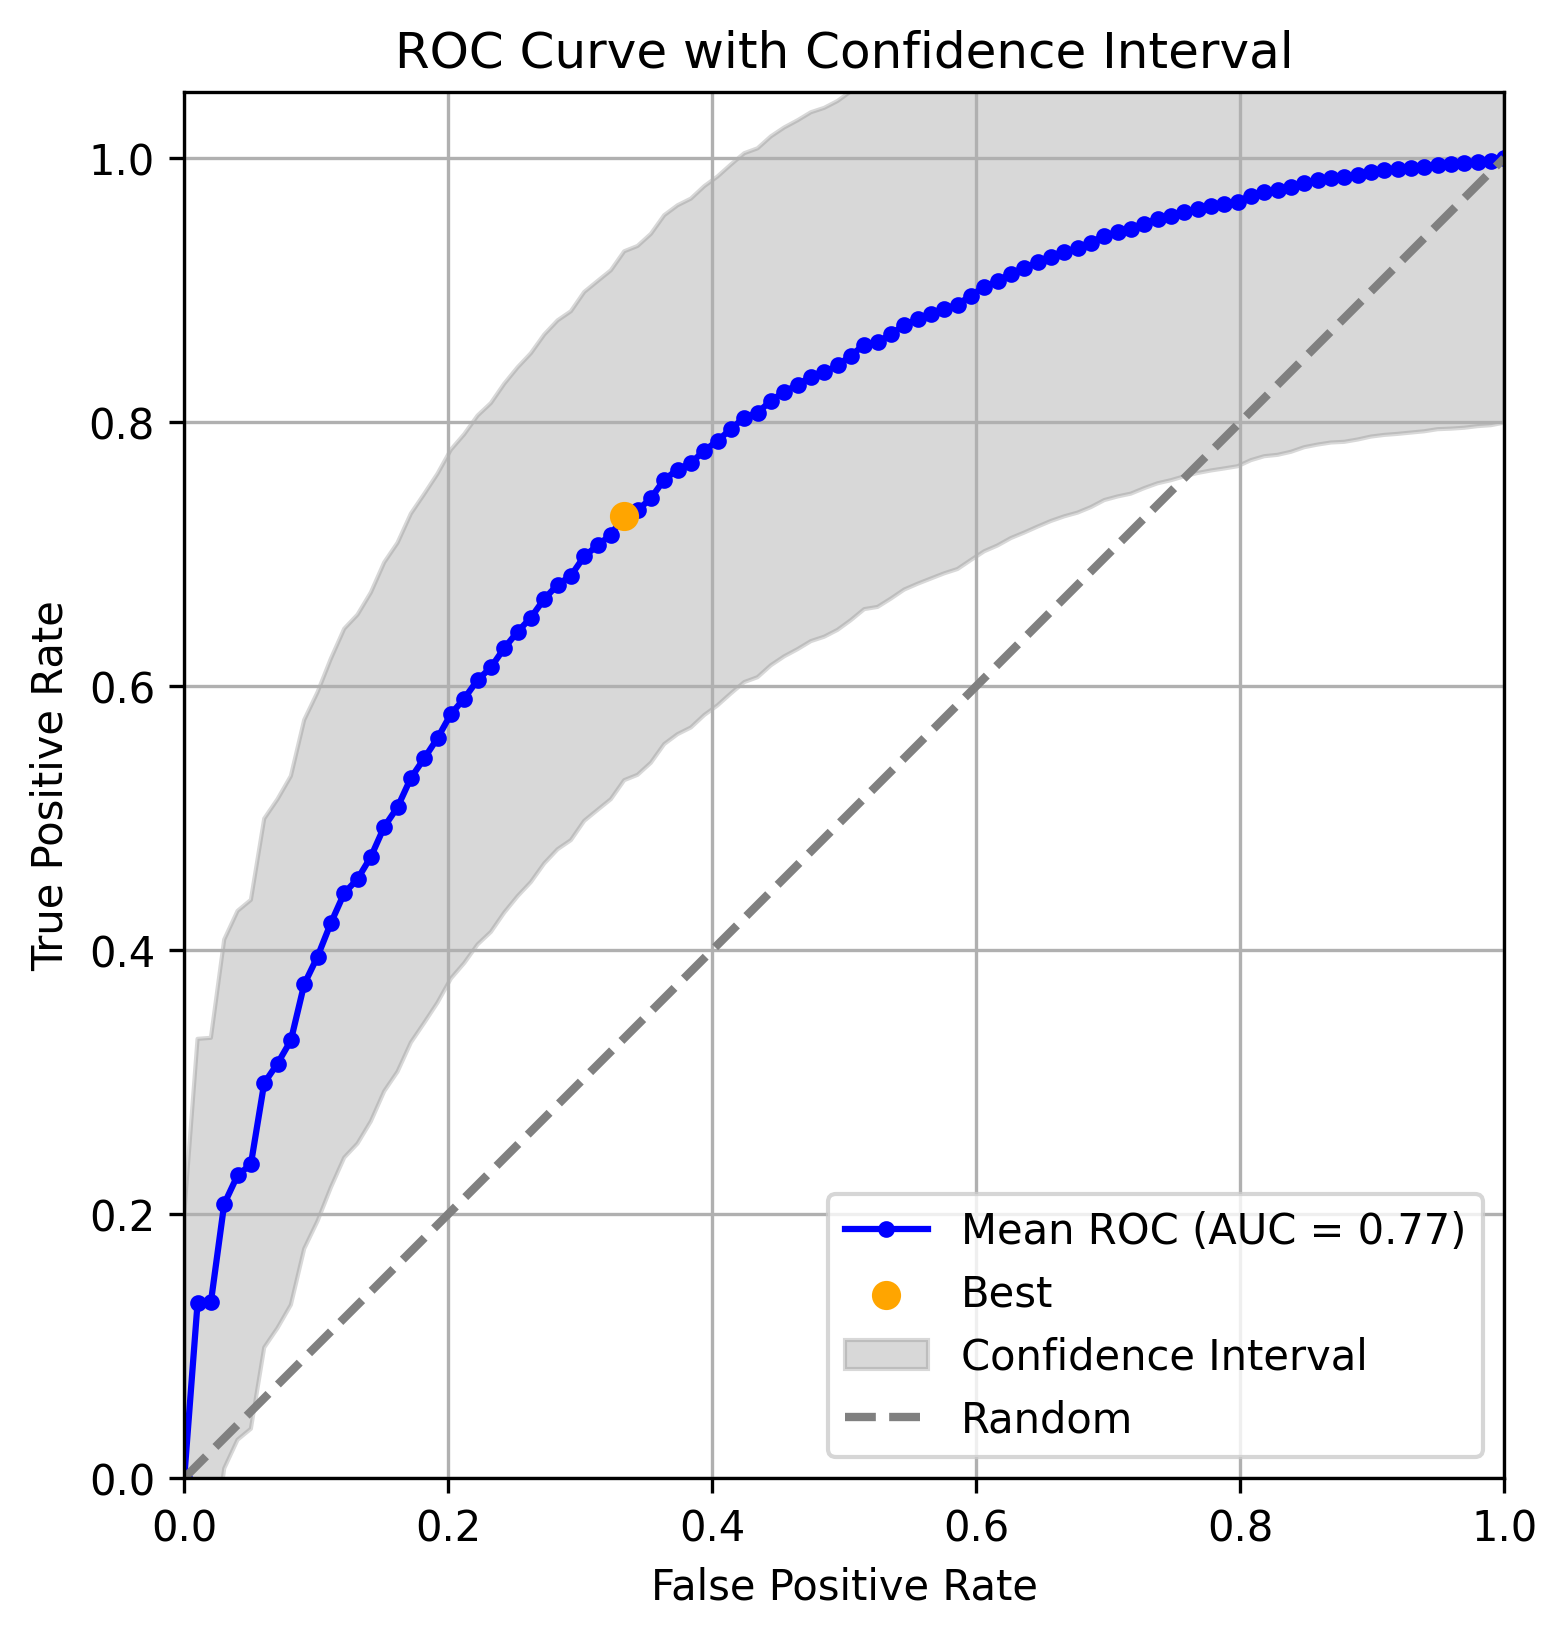

{'optimal_threshold': 0.2526837840560087, 'optimal_sensitivity': 0.7291186507936516, 'optimal_specificity': 0.6666666666666666}


In [147]:
import mlflow
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import auc as auc_metric
import logging

logger = logging.getLogger(__name__)

def calculate_threshold(run):
    if isinstance(run, str):
        run = pd.Series(dict(mlflow.get_run(run).info))

    artifact_uri = run.artifact_uri.removeprefix('file://')

    with open(os.path.join(artifact_uri, 'bootstrap_scores.pkl'), 'rb') as f:
        bootstrap_scores = pickle.load(f)

    tpr_fpr = [score[1] for score in bootstrap_scores]
    fig, cutoff = plot_roc_curve_with_ci(tpr_fpr)
    plt.show()

    print(cutoff)

def plot_roc_curve_with_ci(data_dict):
    """
    Plot ROC curve with visualized confidence interval.

    Parameters:
    data_dict (dict): A list containing dictionaries which have keys 'fpr', 'tpr' and 'thresholds'
    thresholds is used to calculate youden index for optimal threshold

    Returns:
    None
    """
    processed_fpr_tpr = {'fpr': [], 'tpr': [], 'thresholds':[]}
    for d in data_dict:
        processed_fpr_tpr['fpr'].append(d['fpr'])
        processed_fpr_tpr['tpr'].append(d['tpr'])
        processed_fpr_tpr['thresholds'].append(d['thresholds'])

    fpr_list = processed_fpr_tpr['fpr']
    tpr_list = processed_fpr_tpr['tpr']
    threshold_list = processed_fpr_tpr['thresholds']
    auc_values = [auc_metric(fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)]

    # Calculate the mean AUC and standard deviation
    mean_auc = np.mean(auc_values)
    std_auc = np.std(auc_values)

    # Create an array to hold the mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    mean_threshold = np.zeros_like(mean_fpr)

    # Create arrays to store lower and upper bounds of ROC curves
    tprs_upper = []
    tprs_lower = []

    # Calculate ROC curve for each fold and store upper and lower bounds
    for fpr, tpr, thresholds in zip(fpr_list, tpr_list, threshold_list):
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        mean_tpr += interp_tpr

        interp_thresholds = np.interp(mean_fpr, fpr, thresholds)
        interp_thresholds[0] = 0.0
        mean_threshold += interp_thresholds

        tprs_upper.append(interp_tpr + 2 * std_auc)
        tprs_lower.append(interp_tpr - 2 * std_auc)

    # Calculate the mean ROC curve and confidence interval bounds
    mean_tpr /= len(fpr_list)
    mean_threshold /= len(fpr_list)
    idx = np.argmax(mean_tpr - mean_fpr)

    logger.info(f"Optimal cutoff point at {mean_threshold[idx]} with sensitivity {mean_tpr[idx]} and specificity {1-mean_fpr[idx]}")

    tprs_upper = np.array(tprs_upper).T
    tprs_lower = np.array(tprs_lower).T

    # Plot ROC curve
    plt.figure(figsize=(8, 6), dpi=300)
    plt.plot(mean_fpr, mean_tpr, color='b', marker='.', label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.scatter(mean_fpr[idx], mean_tpr[idx],marker='o', color='orange', label='Best', zorder=10)
    plt.fill_between(mean_fpr, tprs_lower.mean(axis=1), tprs_upper.mean(axis=1), color='grey', alpha=0.3,
                     label='Confidence Interval')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random')
    plt.axis('scaled')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Confidence Interval')
    plt.legend(loc='lower right')
    plt.grid(True)
    return plt.gcf(), {'optimal_threshold':mean_threshold[idx], 'optimal_sensitivity':mean_tpr[idx], 'optimal_specificity': 1-mean_fpr[idx]}


calculate_threshold(model1_run_id)


In [5]:
from collections.abc import Mapping
from ast import literal_eval

actual_dict = {'_method_': 'rfe', 'n_jobs': 5}
dict_str = "{'_method_': 'rfe', 'n_jobs': 5}"
actual_str = "rfe"

def process_dict(maybe_dict):
    try:
        eval_dict = literal_eval(maybe_dict)
        if isinstance(eval_dict, Mapping):
            return eval_dict
    except ValueError:
        return maybe_dict
    return maybe_dict


def check_dict(d):
    if isinstance(d, Mapping):
        print('is mapping')
    if isinstance(d, str):
        print('is string')

check_dict(process_dict(actual_dict))
check_dict(process_dict(dict_str))
check_dict(process_dict(actual_str))


is mapping
is mapping
is string


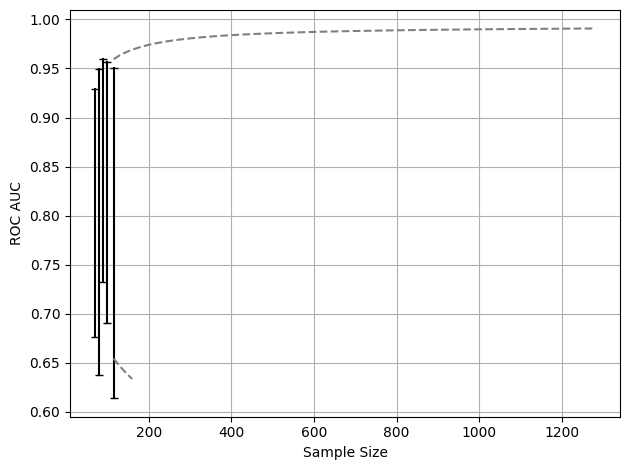

In [112]:
sample_size_dir_list = ['outputs/sample_size_calculation/2024-02-27-06-45-22/sample_size_115.pkl',
                   'outputs/sample_size_calculation/2024-02-27-06-45-22/sample_size_100.pkl',
                   'outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_90.pkl',
                   'outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_80.pkl',
                   'outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_70.pkl']

import pickle

from src.pipeline.sample_size import plot_confidence_intervals

confidence_intervals = []

for sample_size_dir in sample_size_dir_list:
    with open(sample_size_dir, 'rb') as f:
        confidence_intervals.append(pickle.load(f)['roc_auc'])

sample_sizes = [115, 100, 90, 80, 70]

plot_confidence_intervals(sample_sizes, confidence_intervals, 'ROC AUC', save_dir='outputs/sample_size_calculation/2024-02-29-05-18-45/sample_size_calculation.png')

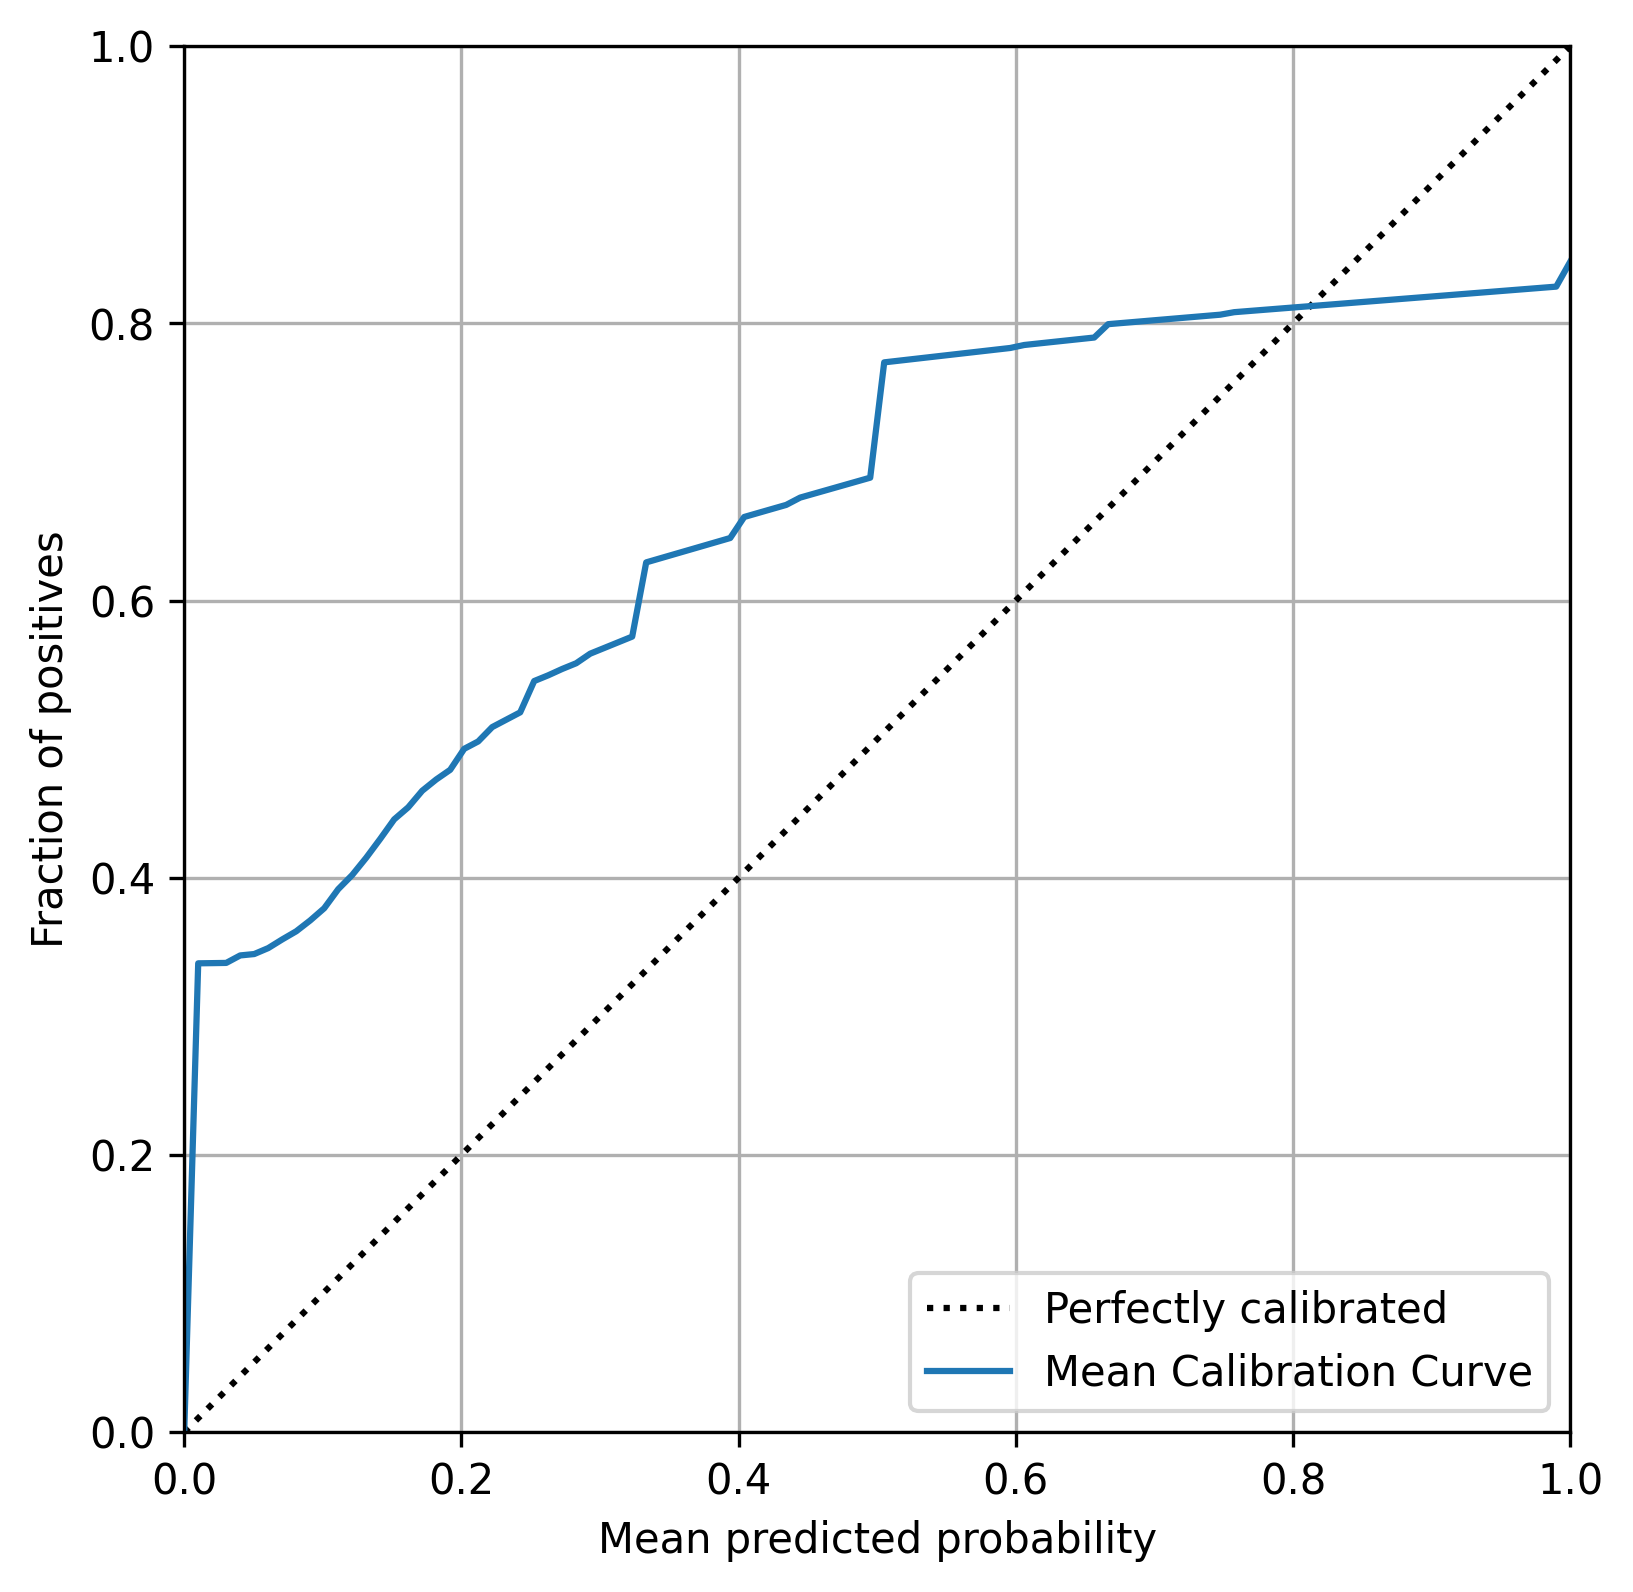

In [151]:
import pickle
from src.analysis.calibration_curve import plot_calibration_curve

model1_run_id = '54b618ca89a549eda3d87a1a57a550fe'
def inspect_optuna_object(run):
    if isinstance(run, str):
        run = pd.Series(dict(mlflow.get_run(run).info))

    artifact_uri = run.artifact_uri.removeprefix('file://')

    plot_calibration_curve(run, save_dir=os.path.join(artifact_uri, 'calibration_curve.png'))

    # with open(os.path.join(artifact_uri, 'optuna_study.pkl'), 'rb') as f:
    #     optuna_study = pickle.load(f)

    # print(optuna_study.trials_dataframe())


inspect_optuna_object(model1_run_id)

# Generate Icons

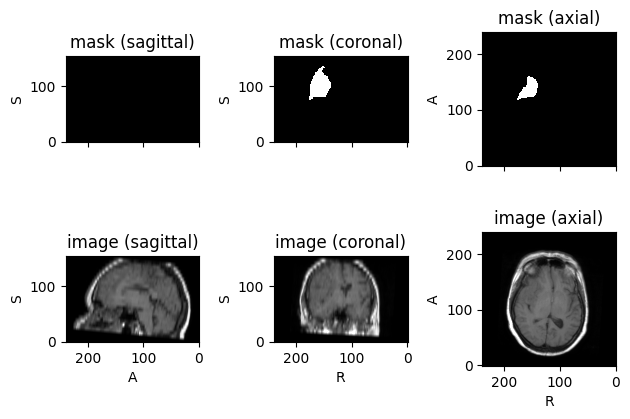

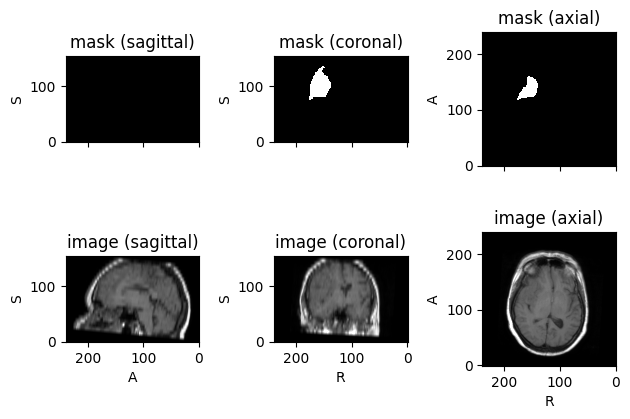

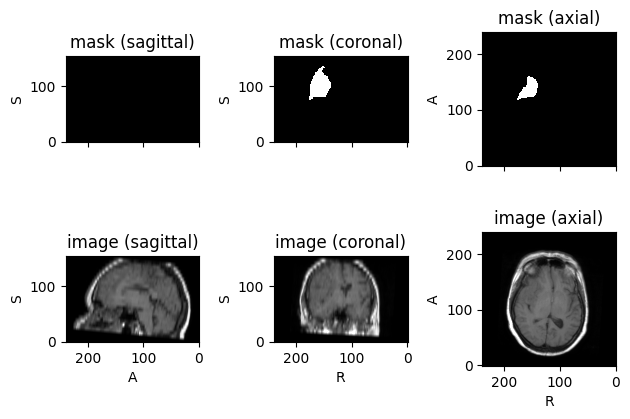

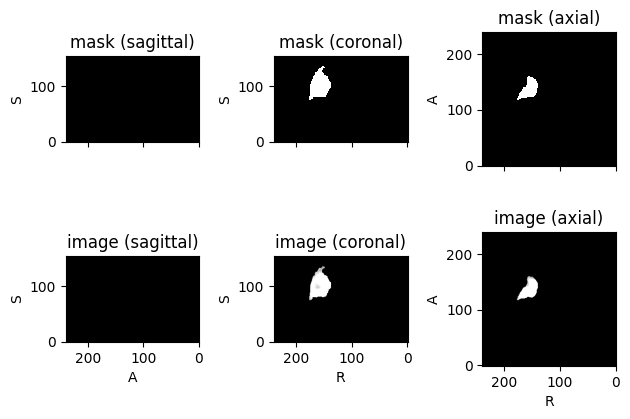

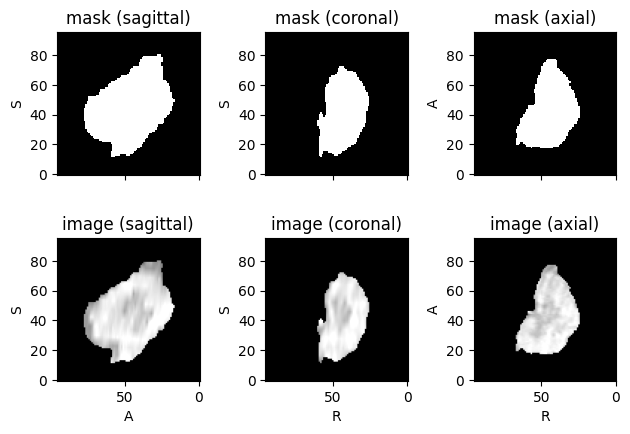

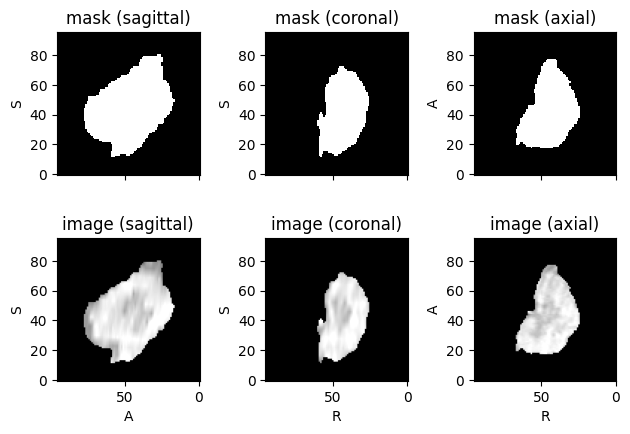

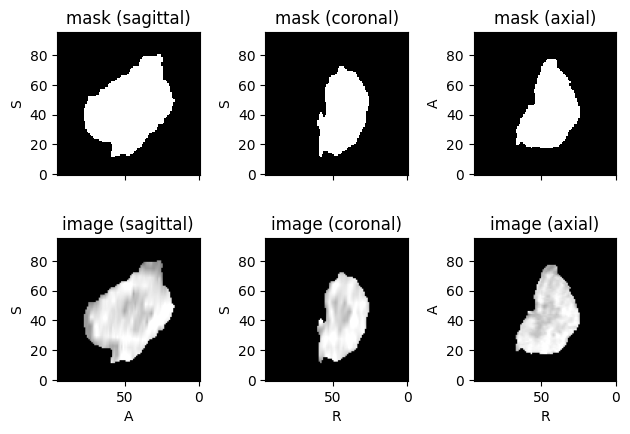

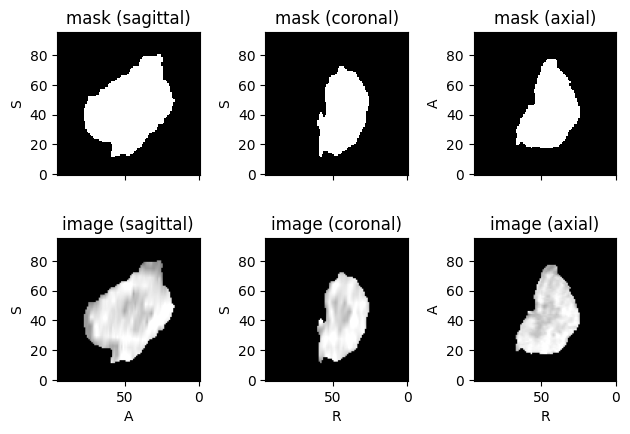

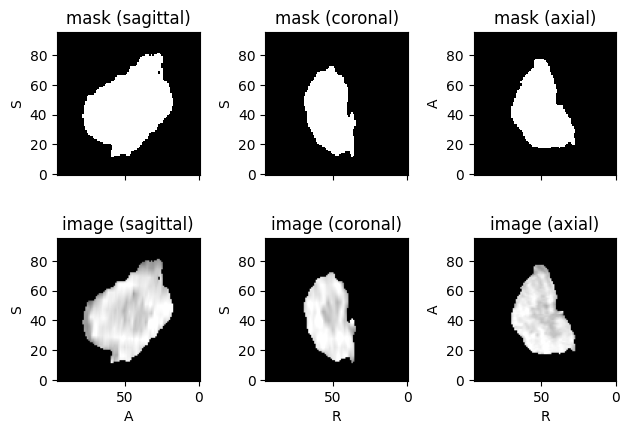

In [75]:
from src.pipeline.pipeline_components import get_data
from autorad.visualization import plot_volumes
import matplotlib.pyplot as plt
import torchio as tio

image_dataset = get_data('./data/meningioma_data', 't1', 'mask')


class Demonstrator:
    def __init__(self, image_dataset, n: int = 1, label:int=1):
        self.image_dataset = image_dataset
        self.case = image_dataset.df.iloc[n]
        self.label = label
    
    def plot_segmented(self):
        image_2D, mask_2D = self.get_2d_image()
        single_plot = plot_volumes.overlay_mask_contour(image_2D, mask_2D)
        fig, axs = plt.subplots(1, 1)
        axs.imshow(single_plot, cmap='gray')
        # axs.set_title(f"{case[image_dataset.ID_colname]}")
        axs.axis("off")
        plt.show()

    def plot_original(self):
        image_2D, mask_2D = self.get_2d_image()
        _, axs = plt.subplots(1,1)
        plt.imshow(image_2D, cmap='gray')
        axs.axis("off")

        plt.show()

    def get_2d_image(self):
        vols = plot_volumes.BaseVolumes.from_nifti(
        self.case[self.image_dataset.image_colname],
        self.case[self.image_dataset.mask_colname],
        window=None,
        label=self.label
        )
        image_2D, mask_2D = vols.get_slices()
        return image_2D, mask_2D

    def plot_transforms(self, transforms):
        tio_subject = tio.Subject(mask=tio.LabelMap(self.case[self.image_dataset.mask_colname]),
                                image=tio.ScalarImage(self.case[self.image_dataset.image_colname]))

        tio_subject.plot()
        for transform in transforms:
            tio_subject = transform(tio_subject)
            tio_subject.plot()


demonstrator = Demonstrator(image_dataset, 10)
# demonstrator.plot_segmented()
# demonstrator.plot_original()
demonstrator.plot_transforms([tio.Resample((1, 1, 1)),
                                tio.ToCanonical(),
                                tio.Mask(masking_method='mask', outside_value=0),
                                tio.CropOrPad(target_shape=(96, 96, 96), mask_name='mask'),
                                tio.ZNormalization(masking_method='mask'),
                                tio.RandomGamma(log_gamma=0.1, label_keys='mask'),
                                tio.RandomAffine(p=0.5, label_keys='mask',
                                                    scales=0.1, degrees=0,
                                                    translation=0, isotropic=True),
                                tio.RandomFlip(flip_probability=0.5,
                                                label_keys='mask', axes=(0, 1, 2))])

(26, 192, 192)


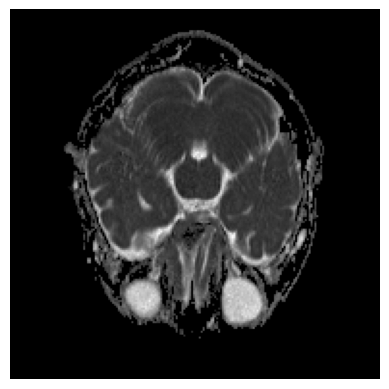

(155, 240, 240)


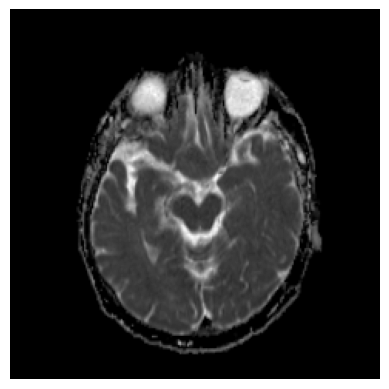

In [61]:
import SimpleITK as sitk

def plot_nifti(path, index):
    image = sitk.ReadImage(path)
    fig, ax = plt.subplots(1,1)
    print(sitk.GetArrayFromImage(image).shape)
    plt.imshow(sitk.GetArrayFromImage(image)[index,:,:], cmap="gray")
    ax.axis('off')
    plt.show()

plot_nifti('data/meningioma_data/ID_1/ADC.nii', 8)

plot_nifti('data/meningioma_data/ID_1/registered_adc.nii.gz', 60)

# Transfer Learning

In [172]:
import numpy as np

def get_total_params(skorch_net):
    if not skorch_net.initialized_:
        skorch_net.initialize()
    parameter_count = []
    for parameter_set in skorch_net.get_all_learnable_params():
        print(f"{parameter_set[0]}: {parameter_set[1].shape}")
    
    return np.sum(parameter_count)


# print(np.prod(list(encoder.get_all_learnable_params())[0][1].shape))
get_total_params(encoder)

convInit.conv.weight: torch.Size([32, 5, 3, 3, 3])
down_layers.0.1.norm1.weight: torch.Size([32])
down_layers.0.1.norm1.bias: torch.Size([32])
down_layers.0.1.norm2.weight: torch.Size([32])
down_layers.0.1.norm2.bias: torch.Size([32])
down_layers.0.1.conv1.conv.weight: torch.Size([32, 32, 3, 3, 3])
down_layers.0.1.conv2.conv.weight: torch.Size([32, 32, 3, 3, 3])
down_layers.1.0.conv.weight: torch.Size([64, 32, 3, 3, 3])
down_layers.1.1.norm1.weight: torch.Size([64])
down_layers.1.1.norm1.bias: torch.Size([64])
down_layers.1.1.norm2.weight: torch.Size([64])
down_layers.1.1.norm2.bias: torch.Size([64])
down_layers.1.1.conv1.conv.weight: torch.Size([64, 64, 3, 3, 3])
down_layers.1.1.conv2.conv.weight: torch.Size([64, 64, 3, 3, 3])
down_layers.1.2.norm1.weight: torch.Size([64])
down_layers.1.2.norm1.bias: torch.Size([64])
down_layers.1.2.norm2.weight: torch.Size([64])
down_layers.1.2.norm2.bias: torch.Size([64])
down_layers.1.2.conv1.conv.weight: torch.Size([64, 64, 3, 3, 3])
down_layers.1

0.0

In [177]:
from src.models.autoencoder.med3d_resnet import med3d_resnet10

restnet10 = med3d_resnet10(sample_input_W=96, sample_input_H=96, sample_input_D=96, shortcut_type='B', num_seg_classes=2)
restnet10



ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 

In [176]:
from src.models.autoencoder import SegResNetVAE2

segresnet2 = SegResNetVAE2(input_image_size=[96,96,96],
                           spatial_dims=3,
                           in_channels=5,
                           out_channels=5,
                           dropout_prob=0.2,
                           init_filters=64)
segresnet2

SegResNetVAE2(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(5, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 128, eps=1

In [77]:
import importlib
importlib.reload(importlib.import_module("src.models.autoencoder.med3d_resnet"))
importlib.reload(importlib.import_module("src.models.autoencoder.segresnet"))
from src.models.autoencoder.med3d_resnet import med3d_resnet10
import torch
import re
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

restnet10 = med3d_resnet10(input_image_size=[96,96,96], shortcut_type='B', in_channels=5,
                           pretrained_param_path='outputs/pretrained_models/resnet_10_23dataset.pth')




# load_pretrained_params(restnet10,'outputs/pretrained_models/resnet_10_23dataset.pth')


# restnet10.state_dict().keys()

DEBUG:src.models.autoencoder.med3d_resnet:convInit.conv1.weight was loaded as torch.Size([64, 5, 7, 7, 7]) from torch.Size([64, 1, 7, 7, 7])
DEBUG:src.models.autoencoder.med3d_resnet:convInit.bn1.weight was loaded as torch.Size([64]) from torch.Size([64])
DEBUG:src.models.autoencoder.med3d_resnet:convInit.bn1.bias was loaded as torch.Size([64]) from torch.Size([64])
DEBUG:src.models.autoencoder.med3d_resnet:convInit.bn1.running_mean was loaded as torch.Size([64]) from torch.Size([64])
DEBUG:src.models.autoencoder.med3d_resnet:convInit.bn1.running_var was loaded as torch.Size([64]) from torch.Size([64])
DEBUG:src.models.autoencoder.med3d_resnet:convInit.bn1.num_batches_tracked was loaded as torch.Size([]) from torch.Size([])
DEBUG:src.models.autoencoder.med3d_resnet:down_layers.layer1.0.conv1.weight was loaded as torch.Size([64, 64, 3, 3, 3]) from torch.Size([64, 64, 3, 3, 3])
DEBUG:src.models.autoencoder.med3d_resnet:down_layers.layer1.0.bn1.weight was loaded as torch.Size([64]) from t

In [87]:
import torch

def inspect_params():

    pretrained_weights = torch.load('outputs/pretrained_models/resnet_10_23dataset.pth', 'cpu')['state_dict']
    # restnet10.to('cpu')
    # print(restnet10.state_dict()['down_layers.layer1.0.conv1.weight'].cpu() == pretrained_weights['module.layer1.0.conv1.weight'].cpu())
    print(pretrained_weights['module.layer1.0.conv1.weight'].get_device())
    # for k, v in pretrained_weights.items():
    #     print(f"{k}: {v.shape}")

inspect_params()

-1


AttributeError: 'ResNetEncoder' object has no attribute 'get_device'

In [89]:
import torchio as tio

tio.RandomGamma(log_gamma=0.1, label_keys=('mask',))

RandomGamma()